# Histogram

I need to get DFM's code working to estimate the histogram, since at the moment it does not appear to be a power law.

In [1]:
from __future__ import print_function, division

import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from george import kernels, GP
import fitters
sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

%matplotlib inline

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Make sample of size 100. Each sample will have 10000 'MCMC' samples to estimate its uncertainty

In [44]:
# Generate the true distribution as a chi-squared, and then make all samples fall in [0,1]
NP_SEED=20
np.random.seed(NP_SEED)
true_q = np.random.chisquare(df=9, size=100)
true_q /= true_q.max()

# Generate samples for each true q from a truncated normal distribution
std = 0.05
a = -true_q / std
b = (1 - true_q) / std
q = np.vstack([stats.truncnorm.rvs(a=ai, b=bi, loc=true_qi, scale=std, size=10000) for ai, bi, true_qi in zip(a, b, true_q)])
#q = np.random.normal(loc=true_q, scale=0.1, size=(10000, true_q.size)).T
#q = np.random.chisquare(df=true_q, size=(10000, true_q.size)).T

(array([    6.,    70.,   418.,  1354.,  2705.,  2996.,  1754.,   578.,
          108.,    11.]),
 array([ 0.48680335,  0.52567937,  0.56455538,  0.6034314 ,  0.64230741,
         0.68118343,  0.72005944,  0.75893545,  0.79781147,  0.83668748,
         0.8755635 ]),
 <a list of 10 Patch objects>)

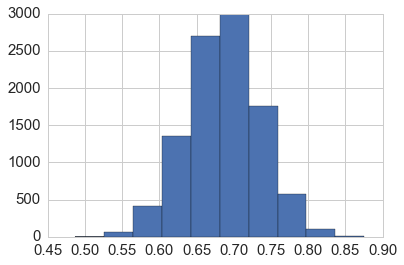

In [45]:
plt.hist(q[10])

### Make a class that will fit this to a smooth distribution (no censoring yet)

In [8]:
class HistFitter(fitters.Bayesian_LS):
    def __init__(self, qvals, bin_edges):
        self.qvals = qvals
        self.bin_edges = bin_edges
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:])/2
        self.bin_widths = np.diff(self.bin_edges)
        self.Nbins = self.bin_widths.size
        self.Nobs = self.qvals.shape[0]
        
        # Find which bin each q falls in
        self.bin_idx = np.digitize(self.qvals, self.bin_edges) - 1
        
        # Determine the censoring function for each bin (used in the integral)
        self.censor_integrals = np.array([integrate.quad(func=self.censoring_fcn,
                                                         a=left, b=right)[0] for (left, right) in 
                                          zip(self.bin_edges[:-1], self.bin_edges[1:])])
    
    def lnlike(self, pars):
        # Pull theta out of pars
        theta = pars[:self.Nbins]
        
        # Normalize theta
        #theta /= np.sum(theta * self.bin_widths)
        
        # Generate the inner summation
        gamma = np.ones_like(self.bin_idx) * np.nan
        good = (self.bin_idx < self.Nbins) & (self.bin_idx >= 0) # nans in q get put in nonexistent bins
        gamma[good] = self.Nobs * theta[self.bin_idx[good]]
        summation = np.nanmean(gamma, axis=1)
        
        # Calculate the integral
        I = self._integral_fcn(theta)
        
        # Generate the log-likelihood
        ll = -I + np.nansum(np.log(summation))
        return ll
    
    def lnprior(self, pars):
        # Pull theta out of pars
        theta = pars[:self.Nbins]
        
        return 0.0
    
    def lnprob(self, pars):
        lp = self.lnprior(pars)
        return lp + self.lnlike(pars) if np.isfinite(lp) else -np.inf
    
    def _integral_fcn(self, theta):
        return np.sum(theta * self.censor_integrals) * self.Nobs
    
    def censoring_fcn(self, q):
        return 1.0
        
    def guess_fit(self):
        from scipy.optimize import minimize
        
        def errfcn(pars):
            ll = self.lnprob(pars)
            #print(pars, ll)
            return -ll

        initial_guess = np.ones_like(self.bin_centers)
        bounds = [[1e-3, None] for p in initial_guess]
        out = minimize(errfcn, initial_guess, bounds=bounds)
        return out.x
        

In [39]:
bins = np.arange(0, 1.05, 0.1)
hf = HistFitter(q, bin_edges=bins)

In [40]:
theta, _ = np.histogram(true_q, bins=bins, normed=True)
hf.lnlike(theta)

377.10431262395764

In [41]:
fit_pars = hf.guess_fit()

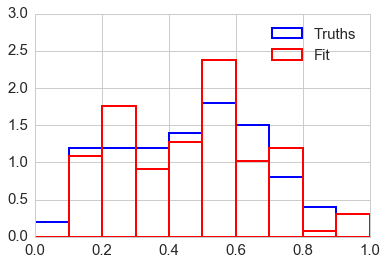

In [43]:
# Plot
plt.bar(left=bins[:-1], width=hf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=hf.bin_widths, height=fit_pars, label='Fit', fill=False, lw=2, edgecolor='red')
plt.ylim((0, 3.0))
plt.legend(loc='best', fancybox=True)

## That seems to work pretty well! Lets add some complexity by adding a censoring function

(-0.05, 1.05)

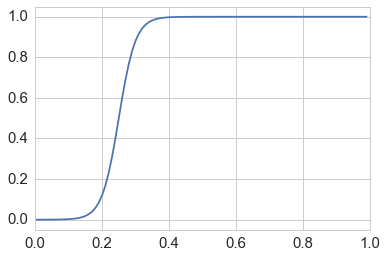

In [46]:
# I will make the censoring function be a sigmoid, but will only use the callable 
def sigmoid(q, alpha, beta):
    return 1.0 / (1.0 + np.exp(-alpha * (q - beta)))

alpha, beta = (40, 0.25)
x = np.arange(0, 1, 0.01)
Q = sigmoid(x, alpha, beta)
plt.plot(x, Q)
plt.ylim((-0.05, 1.05))

In [47]:
# Censor out some of the q, replacing all with nans
R = np.random.uniform(size=true_q.size)
undetected = R > sigmoid(true_q, alpha, beta)
censored_q = q.copy()
censored_q[undetected, :] = np.nan

(array([  0.,   4.,   5.,  12.,  14.,  18.,  15.,   8.,   4.,   3.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

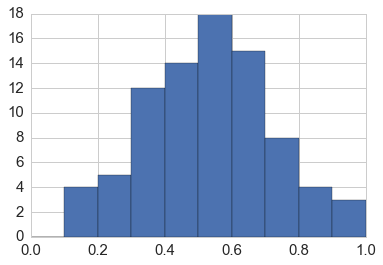

In [48]:
plt.hist(true_q[~undetected], bins=bins)

In [49]:
class CensoredHistFitter(HistFitter):
    def censoring_fcn(self, q):
        return sigmoid(q, alpha, beta)
        #return 1.0

In [50]:
chf = CensoredHistFitter(censored_q, bins)
fit_pars = chf.guess_fit()

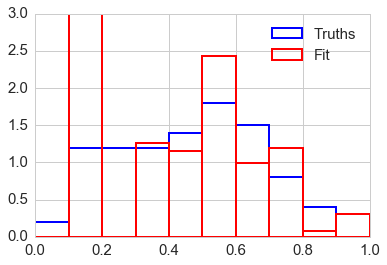

In [52]:
# Plot
plt.bar(left=bins[:-1], width=chf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=chf.bin_widths, height=fit_pars, label='Fit', fill=False, lw=2, edgecolor='red')
plt.ylim((0, 3.0))
plt.legend(loc='best', fancybox=True)

### Cool! That mostly gives a reasonable answer too.

Now, I need to add a prior in the form of a gaussian process that forces the histogram to be 'smooth'

In [53]:
class SmoothHistFitter(CensoredHistFitter):
    def lnprior(self, pars):
        theta = pars[:self.Nbins]
        if np.any(theta < 0):
            return -np.inf
        a, tau, err = np.exp(pars[self.Nbins:-1])
        mean = pars[-1]
        kernel = a * kernels.ExpSquaredKernel(tau)
        gp = GP(kernel, mean=mean)
        gp.compute(self.bin_centers, yerr=err)
        return gp.lnlikelihood(theta)
    
    def guess_fit(self):
        from scipy.optimize import minimize
        
        def errfcn(pars):
            ll = self.lnprob(pars)
            #print(pars, ll)
            return -ll

        initial_guess = np.ones(self.bin_centers.size + 4)
        initial_guess[-4] = -3.0
        initial_guess[-3] = -0.25
        initial_guess[-2] = -1.0
        initial_guess[-1] = -1.0
        bounds = [[1e-3, None] for p in self.bin_centers]
        bounds.append([-20, 0])
        bounds.append([-10, 10])
        bounds.append((-1, 5))
        bounds.append((-10, 10))
        print(initial_guess)
        out = minimize(errfcn, initial_guess, bounds=bounds)
        return out.x
    
    def _lnlike(self, pars):
        return self.lnprob(pars)
    
    def mnest_prior(self, cube, ndim, nparams):
        for i in range(self.Nbins):
            cube[i] *= 5
        #cube[:self.Nbins] *= 15
        cube[self.Nbins] = cube[self.Nbins] * 20 - 20
        cube[self.Nbins+1] = cube[self.Nbins+1] * 20 - 10
        cube[self.Nbins+2] = cube[self.Nbins+2] * 7 - 2
        cube[self.Nbins+3] = cube[self.Nbins+3] * 20 - 10
        return
        
        

In [54]:
shf = SmoothHistFitter(censored_q, bins)
#shf.lnprob(fit_pars)

In [55]:
fit_pars = shf.guess_fit()

[ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   -3.   -0.25
 -1.   -1.  ]


In [56]:
print(fit_pars)

[ 1.32166028  1.5833721   1.39693359  1.21012614  1.40584305  1.55093253
  1.2412631   0.88649444  0.44234046  0.32971629 -2.0544147  -2.88321824
 -1.          1.07046876]


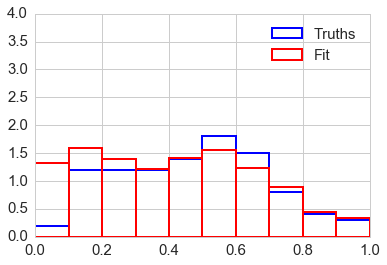

In [57]:
plt.bar(left=bins[:-1], width=shf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=fit_pars[:-4], label='Fit', fill=False, lw=2, edgecolor='red')
plt.ylim((0, 4.0))
plt.legend(loc='best', fancybox=True)

In [ ]:
shf.n_params = shf.Nbins + 4
shf.param_names = [r'$\theta_{}$'.format(i) for i in range(shf.Nbins)]
shf.param_names.extend(('lna', 'lntau', 'lnerr', 'mean'))
shf.fit_multinest(basename='HistFitterTest/simulation{}'.format(NP_SEED), overwrite=False)

In [ ]:
shf.triangle(hist_kwargs=dict(lw=2))

In [ ]:
shf.samples.describe()

In [ ]:
height_mean = np.array([shf.samples[col].mean() for col in shf.param_names[:shf.Nbins]])
height_std = np.array([shf.samples[col].std() for col in shf.param_names[:shf.Nbins]])
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='Fit', fill=False, lw=2, edgecolor='red')
plt.ylim((0, 4.0))
plt.legend(loc='best', fancybox=True)

In [35]:
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
print(m)
print(m-l)
print(h-m)

[ 0.38259558  0.79900356  1.34131517  1.711171    1.4483948   0.84794084
  0.45383845  0.16948505  0.08765242  0.17846362]
[ 0.26090428  0.50377782  0.79242045  0.947444    0.82825019  0.51646315
  0.25145652  0.11338463  0.061153    0.10729933]
[ 0.53337932  0.73287828  1.10237049  1.43878044  1.17705034  0.73039294
  0.39365756  0.2178711   0.15550175  0.22557557]


In [ ]:
import emcee

nwalkers = 100
ndim = fit_pars.size

p0 = emcee.utils.sample_ball(fit_pars, std=0.1*np.ones_like(fit_pars), size=nwalkers)

fitter = emcee.EnsembleSampler(nwalkers, ndim, shf.lnprob)

In [ ]:
output = fitter.run_mcmc(p0, 1000)

In [ ]:
#shf.lnprior(fit_pars), shf.lnlike(fit_pars), shf.lnprob(fit_pars)
print(shf.lnprob(fit_pars))
p = fit_pars.copy()
p[-2] = 5
print(shf.lnprob(p))

In [ ]:
sigma = 0.1
bini, binj = np.meshgrid(shf.bin_centers, shf.bin_centers)
cov = 1.0 * np.exp(-0.5*(bini-binj).T * sigma**(-2) * (bini-binj))
cov += np.eye(shf.bin_centers.size) * 1e-3
stats.multivariate_normal.pdf(shf.bin_centers, cov=cov, mean=np.zeros_like(shf.bin_centers))

In [ ]:
np.linalg.det(cov)

In [ ]:
np.eye(10)

In [ ]:
minimize?